# Homework 3 Arno Strouwen
## Part 2 Addendum
In this notebook we unsuccessfully try to segment all the classes in the images.
Since the workflow is identical to the foreground/background segmentation, I will not expand on the details.

In [10]:
from typing import List, Tuple
import os
import xml.etree.ElementTree as etree
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow_examples.models.pix2pix import pix2pix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
path_to_VOC_folder = os.path.join("VOCdevkit","VOC2012") # adjust path to your location
_IMAGE_SHAPE=(128,128)
_VOC_LABELS = (
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor",
)
def get_segmentation_paths(base_dir):
  IMAGE_PATH = os.path.join(base_dir,'JPEGImages')
  ANNOTATION_PATH = os.path.join(base_dir,'SegmentationClass')
  LISTS=os.path.join(base_dir,'ImageSets','Segmentation')
  image_files_paths = []
  annotations_paths = []
  names=[]
  with open(os.path.join(LISTS,'trainval.txt' )) as f:
    for line in f:
      names.append(line[:-1])
    
  for name in names:
    image_files_paths.append(os.path.join(IMAGE_PATH,name+'.jpg'))
    annotations_paths.append(os.path.join(ANNOTATION_PATH, name+'.png'))

  return image_files_paths, annotations_paths

def get_mask(path):
  mask =np.array(Image.open(path.numpy()).resize(_IMAGE_SHAPE))
  return mask

def _load_image_and_mask_py(im_path,mask_path):
  img_raw = tf.io.read_file(im_path)
  img = tf.io.decode_image(img_raw, dtype=tf.dtypes.uint8,expand_animations = False)
  img=tf.image.resize(img,_IMAGE_SHAPE,preserve_aspect_ratio=False,antialias=True)

  # tf.io.decode_image does not recognize the png file properly, we need to load it with PIL
  mask =np.array(Image.open(mask_path.numpy()).resize(_IMAGE_SHAPE))

  # uncomment as needed:
  # foreground/background segmentation:
  #mask[mask>0]=1

  # segment all classes:
  mask[mask==255]=21
  # 255 is a outline/difficult label. You can predict this as a 21st class, or ignore it by setting =0
  return img,mask

def load_image_and_mask(x,y,preprocess):
  # this is needed because we need to load the masks from png files using the PIL library.
  # This is done inside a tf.py_function to prevent tf from running this part of the ds in a graph.
  x,y= tf.py_function(func=_load_image_and_mask_py,inp=[x,y], Tout=(tf.float32,tf.uint8))
  # The output shape of tf.py_fucntions are unknown, this will cause issues when compiling models with metrics
  # and runing model.fit in graph execution (the default behaviour)
  x.set_shape(tf.TensorShape([None,None,None]))
  if preprocess:
      x = tf.keras.applications.mobilenet.preprocess_input(x)
  y.set_shape(tf.TensorShape([None,None]))
  return x,y

In [3]:
image_paths, annotation_paths = get_segmentation_paths(path_to_VOC_folder)

In [4]:
X_train, X_rest, y_train, y_rest=train_test_split(image_paths, annotation_paths,
                                                  train_size=0.7, shuffle=True, random_state=2022)
X_val, X_test, y_val, y_test=train_test_split(X_rest, y_rest,
                                                  train_size=0.5, shuffle=True, random_state=2022)
print(f'train samples: {len(X_train)} \nval samples: {len(X_val)} \ntest samples: {len(X_test)}')

train samples: 2039 
val samples: 437 
test samples: 437


In [5]:
image_size = 128
batch_size = 32
def create_data_set(X,Y,preprocess):
    ds=tf.data.Dataset.from_tensor_slices((X,Y))
    ds=ds.shuffle(buffer_size=5000)
    ds=ds.map(lambda x,y :load_image_and_mask(x,y,preprocess),num_parallel_calls=tf.data.AUTOTUNE)
    ds=ds.cache()
    ds=ds.prefetch(tf.data.AUTOTUNE)
    ds=ds.batch(batch_size)
    return ds

ds_train_pp = create_data_set(X_train,y_train,True)
ds_val_pp = create_data_set(X_val,y_val,True)
ds_test_pp = create_data_set(X_test,y_test,True)
ds_test_no_pp = create_data_set(X_test,y_test,False)

In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[image_size, image_size, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = True
# mask from features model
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [7]:
output_channels = len(_VOC_LABELS) + 2
def build_model(hp):
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-4, sampling="log")
    learning_decay = hp.Float("decay", min_value=0.5, max_value=0.99)
    last_layer_Conv2DTranspose = hp.Boolean("last")

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
  # This is the last layer of the model
    if last_layer_Conv2DTranspose: 
        last = tf.keras.layers.Conv2DTranspose( filters=output_channels, kernel_size=3, strides=2, padding='same')  #64x64 -> 128x128
    else:
        x = layers.UpSampling2D()(x) #64x64 -> 128x128
        last = layers.Conv2D(filters=output_channels, kernel_size=3, padding='same')
    outputs = last(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,decay_steps=1,decay_rate=learning_decay)
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=schedule),
                  loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [17]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="BO4",
    overwrite=False,
)
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]
tuner.search(ds_train_pp,epochs=50,validation_data=ds_val_pp,callbacks=callbacks,verbose=2)

Trial 21 Complete [00h 05m 16s]
val_loss: 1.2954498529434204

Best val_loss So Far: 1.2954498529434204
Total elapsed time: 00h 05m 16s
INFO:tensorflow:Oracle triggered exit


In [18]:
ds_full_train_pp = ds_train_pp.concatenate(ds_val_pp)
best_hps = tuner.get_best_hyperparameters(1)
final_model_structure =  build_model(best_hps[0])
history = final_model_structure.fit(ds_full_train_pp , epochs=10)

Epoch 1/10
78/78 [==============================] - 12s 89ms/step - loss: 1.9938 - accuracy: 0.5513
Epoch 2/10
78/78 [==============================] - 7s 90ms/step - loss: 1.3330 - accuracy: 0.7102
Epoch 3/10
78/78 [==============================] - 7s 87ms/step - loss: 1.2131 - accuracy: 0.7131
Epoch 4/10
78/78 [==============================] - 7s 89ms/step - loss: 1.1745 - accuracy: 0.7150
Epoch 5/10
78/78 [==============================] - 7s 89ms/step - loss: 1.1588 - accuracy: 0.7161 0s - loss: 1.152
Epoch 6/10
78/78 [==============================] - 7s 86ms/step - loss: 1.1519 - accuracy: 0.7166
Epoch 7/10
78/78 [==============================] - 7s 88ms/step - loss: 1.1488 - accuracy: 0.7169
Epoch 8/10
78/78 [==============================] - 7s 93ms/step - loss: 1.1474 - accuracy: 0.7170 1s - loss: 1
Epoch 9/10
78/78 [==============================] - 7s 88ms/step - loss: 1.1468 - accuracy: 0.7170
Epoch 10/10
78/78 [==============================] - 7s 88ms/step - loss: 1.14

images


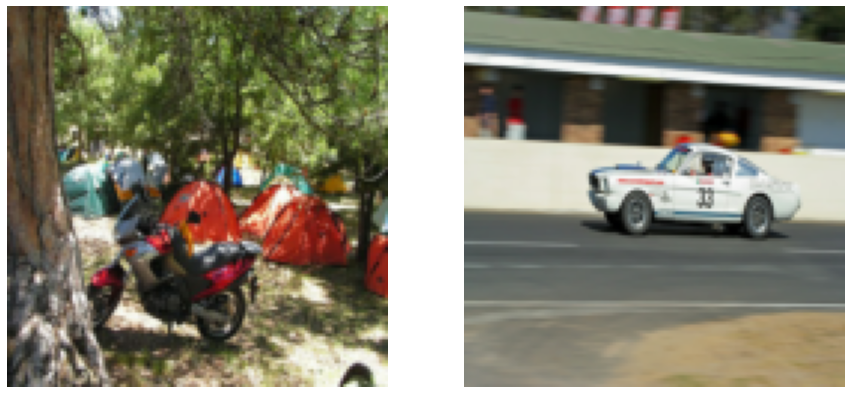

true mask


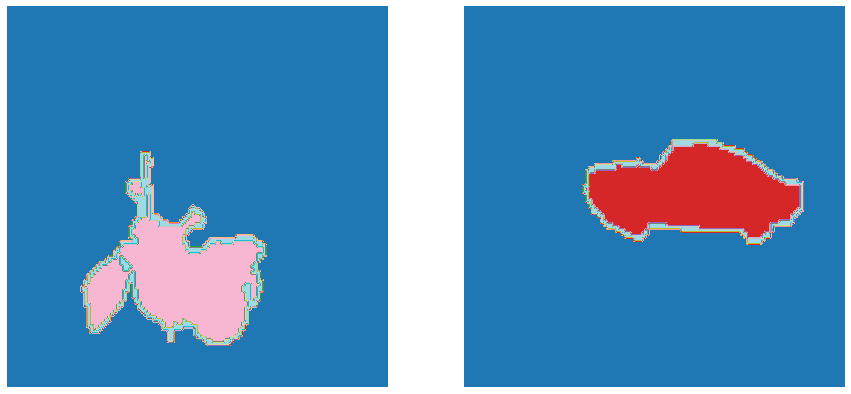

predicted mask


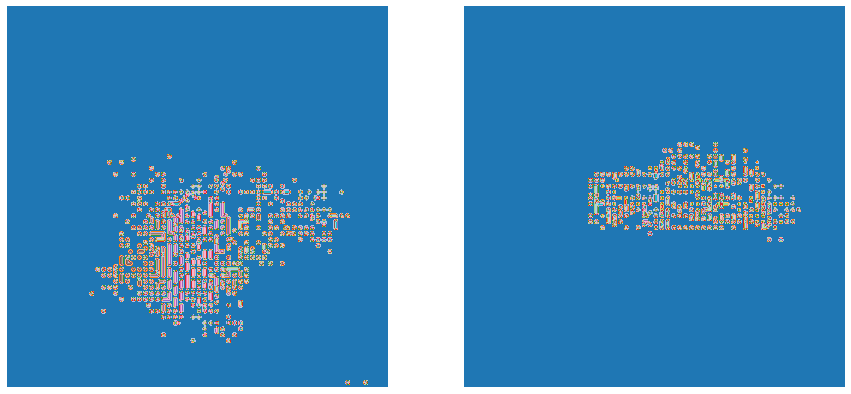

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
x,y = iter(ds_test_no_pp).next()
preds = final_model_structure.predict(tf.keras.applications.mobilenet.preprocess_input(x))
num_images = 2
print("images")
plt.figure(figsize=(15,15))
for i in range(num_images):
  ax=plt.subplot(1,num_images,i+1)
  ax.imshow(x[i].numpy().astype('uint8'))
  ax.axis('off')
plt.show()
print("true mask")
plt.figure(figsize=(15,15))
for i in range(num_images):
  ax=plt.subplot(1,num_images,i+1)
  ax.imshow(y[i].numpy().astype('uint8'), cmap='tab20')
  ax.axis('off')
plt.show()
print("predicted mask")
plt.figure(figsize=(15,15))
for i in range(num_images):
  ax=plt.subplot(1,num_images,i+1)
  masker = create_mask(preds[i:i+1,:,:,:])
  ax.imshow(masker.numpy().astype('uint8'), cmap='tab20')
  ax.axis('off')
plt.show()

The network seems to vaguely be able to detect objects, but segmenting the object into the correct class is hopeless.
This task is too difficult to achieve within the class of model structures that only take minutes to train, so I only focussed on foreground/background segmentation.